In [1]:
from icecube import icetray, dataio, dataclasses, simclasses, phys_services, recclasses
import os, sys
import numpy as np
import matplotlib as mpl
from matplotlib.colors import LogNorm, Normalize
import matplotlib.pyplot as plt
import timeit as time
import math
from datetime import datetime
import timeit

In [2]:
# Added by JP
# Define the directory of your files
files_dir = '/data/icecube/domeff_analysis/reco_sim_nominal/0000000-0000999'
# List the contents of the entire directory
file_list_aux = os.listdir(files_dir)
# Only keep those that are I3 files
file_list = [x for x in file_list_aux if '.i3.bz2' in x]
print('Total files', len(file_list))

Total files 966


In [3]:
#I would recommend you write a function that takes a frame as input 
#and returns the corrected charge for that event. 
#Inside, the function should pick the muon and loop over all the doms that have seen light, 
#and return the corrected charges of all doms, as an array. So each event gives you an array as the output.

In [4]:
# Now decide how many files to loop over
nfiles = 1 # This can be len(file_list)

In [5]:
def func(frame,frame_arr, counter_single,counter_multi_reject,  volume_radius, volume_top):
    pulses = frame['SRTInIcePulsesDOMeff'].apply(frame)
    one_dom = pulses.items()
    
    muon_index = np.zeros(len(frame_arr),dtype=int)
    charge = []
    times = []
    min_time_ar = []
    mydom = []
    distance = []
    
    for index, frame in enumerate(frame_arr):
        

        mmc_tracks = frame['MMCTrackList']
    
        if len(mmc_tracks) == 1:
            muon_index[index] = 0
            counter_single += 1
        else:
       
            muons_in_volume = 0
            for itrack, one_track in enumerate(mmc_tracks):
           
                if (np.sqrt(one_track.xc**2 + one_track.yc**2) < volume_radius) and (-volume_top<one_track.zc<volume_top):
              
                    if one_track.particle.shift_along_track(one_track.particle.length).z < volume_top:
                                  
                        muons_in_volume += 1
                        muon_index[index] = itrack
        
            if muons_in_volume > 1:
                muon_index[index] = -1
                counter_multi_reject += 1


    for i, frame in enumerate(frame_arr):
        if muon_index[i] < 0:
            continue   
    
    for i in range(len(one_dom)):
        Omkey= one_dom[i][0]
        and_time = one_dom[i][1]
        #print(Omkey,and_time)

        value = []
        char = 0
        for pulse in one_dom[i][1]:
            time_pulse = 0
            time_pulse += pulse.time
            value.append(time_pulse)
            times.append(time_pulse)
        
            char += pulse.charge
            if char > 0 :
                charge.append(char)
    

    min_time_ar.append(min(value))

    #print(value)
    #print(min_time_ar)
    #print(times)
    #print(len(value))
    #print(len(times))
 
    
    for i in range(len(value)-1):
        #print(times[len(times) - i - 1])
        if times[len(times) - i - 1] != min_time_ar: del times[len(times) - i - 1]
    #print(times)

   
     
    
    gcd_file = '/cvmfs/icecube.opensciencegrid.org/data/GCD/GeoCalibDetectorStatus_IC86_Merged.i3.gz'
    gfile = dataio.I3File(gcd_file)
    gframe = gfile.pop_frame()
    geometry = gframe['I3Geometry']
    
   
    for i in range(len(one_dom)):
        dom = geometry.omgeo[one_dom[i][0]]    
        mydom.append(dom) 
        
    mmctracks = frame['MMCTrackList']
    track = mmctracks[0].particle
    
    x_f = y_f = z_f = 0
    x_e = y_e = z_e = 0
    for i in range(len(mydom)):
        if times[i] == max(times):
            x_f = mydom[i].position.x
            y_f = mydom[i].position.y
            z_f = mydom[i].position.z
            
    for i in range(len(mydom)):
        if times[i] == min(times):
            x_e = mydom[i].position.x
            y_e = mydom[i].position.y
            z_e = mydom[i].position.z
   
    dis = np.sqrt((x_f - x_e)**2 + (y_f - y_e)**2 + (z_f - z_e)**2)
    
    
    for i in range(len(mydom)):
        d = phys_services.I3Calculator.cherenkov_distance(track, mydom[i].position)
        distance.append(d)
    #print(len(distance))
    #print(len(charge))
    
    corrected_charge = []
    for i in range(len(distance)):
        att_length = 50. 
        if distance[i] <= 200.0:
            corrected = charge[i]*distance[i]
            corrected_charge.append(corrected)
        
    
    return corrected_charge, dis, times, one_dom

In [6]:
def function(frame_arr, counter_single,counter_multi_reject, volume_radius, volume_top):

    muon_index = np.zeros(len(frame_arr),dtype=int)
    for index, frame in enumerate(frame_arr):
        

        mmc_tracks = frame['MMCTrackList']
    
        if len(mmc_tracks) == 1:
            muon_index[index] = 0
            counter_single += 1
        else:
       
            muons_in_volume = 0
            for itrack, one_track in enumerate(mmc_tracks):
           
                if (np.sqrt(one_track.xc**2 + one_track.yc**2) < volume_radius) and (-volume_top<one_track.zc<volume_top):
              
                    if one_track.particle.shift_along_track(one_track.particle.length).z < volume_top:
                                  
                        muons_in_volume += 1
                        muon_index[index] = itrack
        
            if muons_in_volume > 1:
                muon_index[index] = -1
                counter_multi_reject += 1
        

    daughters = []

    e_stochastic = []


    for i, frame in enumerate(frame_arr):
        #if muon_index[i] < 0:
         #   continue
        
        mmc_tr = frame['MMCTrackList'][int(muon_index[i])]
        mctree = frame['I3MCTree']
 

    
    
        daughters=(mctree.get_daughters(mmc_tr.particle))

    
        e_stochastic.append(0)
        for d in daughters:
        
            if (d.pos.z <= volume_top) and (np.sqrt(d.pos.x**2 + d.pos.y**2)< volume_radius):
            
                e_stochastic[-1] += d.energy
    
            

    daughters = np.array(daughters)
    e_stochastic = np.array(e_stochastic)
    return e_stochastic

In [7]:
frame_arr = []; mctree = []
volume_radius = 500. # In meters
volume_top    = 500. # In meters
counter_single = 0
counter_multi_reject = 0

In [8]:


start = timeit.default_timer()

frame_arr = []; mctree = []
stoch_ar = []

total_ar = []
std_ar =[]
#ratio_ar = []
#max_cor_ar = []
#mean_cor_ar =[]
#dist_ar = []

for i in range(nfiles):
    with dataio.I3File(os.path.join(files_dir,file_list[i])) as infile:
        for frame in infile:
            if infile.stream.id != 'P': continue 
            frame_arr.append(frame)
            mctree.append(frame['I3MCTree'])
                
            corrected = func(frame,frame_arr, counter_single,counter_multi_reject,  volume_radius, volume_top)[0]
            #dom_distance = func(frame)[1]
            
            total = np.sum(corrected)
            std = np.std(corrected)
            #max_cor = np.max(corrected)
            #mean_cor =np.mean(corrected)
            #ratio = max_cor/mean_cor
            total_ar.append(total)
            #max_cor_ar.append(max_cor)
            #mean_cor_ar.append(mean_cor)
            #ratio_ar.append(ratio)
            std_ar.append(std)
            
            #dist_ar.append(dom_distance)
            
            #stoch_ar.append(stochastic( frame, volume_radius, volume_top, muon_index, counter_single, counter_multi_reject))
            #stoch_ar.append(stochastic( frame))

#ratio_ar = np.array(ratio_ar)
#max_cor_ar = np.array(max_cor_ar)
#mean_cor_ar = np.array(mean_cor_ar)                    
#dist_ar = np.array(dist_ar)
stop = timeit.default_timer()

print('Time: ', stop - start)       


/home/users/sstesnyash/jupyter_py3-4.1.0/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/users/sstesnyash/jupyter_py3-4.1.0/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/users/sstesnyash/jupyter_py3-4.1.0/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Time:  73.3410783931613


In [9]:
std_ar = np.array(std_ar)
total_ar = np.array(total_ar)


In [10]:
print('Total charge', len(total_ar) )
#print('distance between first and last doms', dom_distance)
#print('Average charge per meter, dividing total charge over the distance of first/last dom with light', np.sum(corrected) / dom_distance)
print('Standard deviation', len(std_ar))
#print('Maximum corrected charge observed',max_cor )
#print('Mean corrected charge observed', mean_cor)
#print('Ratio',max_cor/mean_cor )
#print('Stochastic', len(energy(frame_arr)))


    

Total charge 1403
Standard deviation 1403


In [11]:
losses = function(frame_arr, counter_single,counter_multi_reject, volume_radius, volume_top)

In [12]:
len(losses)

1403

Text(0, 0.5, 'Events')

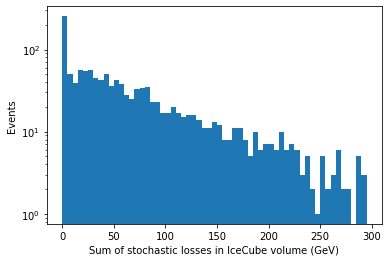

In [13]:
plt.hist(losses, np.arange(0, 300, 5))
plt.yscale('log')
plt.xlabel('Sum of stochastic losses in IceCube volume (GeV)')
plt.ylabel('Events')

Text(0, 0.5, 'std')

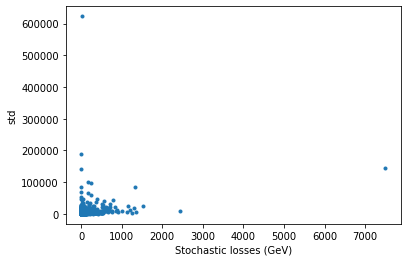

In [14]:
plt.plot(losses, total_ar, '.')
plt.xlabel('Stochastic losses (GeV)')
plt.ylabel('std')


(0.0, 300.0)

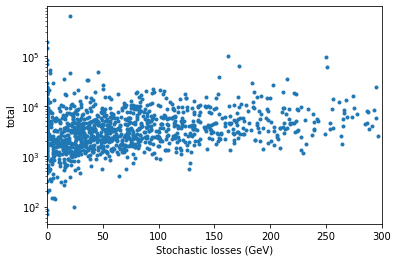

In [15]:
plt.yscale('log')
plt.plot(losses, total_ar , '.')
plt.xlabel('Stochastic losses (GeV)')
plt.ylabel('total')
plt.xlim(0,300)

/home/users/sstesnyash/jupyter_py3-4.1.0/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  


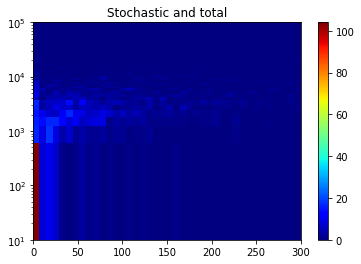

In [16]:
plt.yscale('log')
plt.hist2d(losses, total_ar , bins=(1000, 1000), cmap=plt.cm.jet)
plt.colorbar()
plt.xlim(0,300)
plt.ylim(10,100000)

plt.title('Stochastic and total')
plt.show()

In [17]:
### Decide on the flux you will be using
from icecube.weighting import fluxes
#fluxes.GaisserH3a
flux_to_use = fluxes.GaisserH4a()

In [18]:
def getCorsikaWeight(corsika_weight_map, myflux):
    corsika_weight_map = frame['CorsikaWeightMap']
    pflux = myflux(corsika_weight_map['PrimaryEnergy'], corsika_weight_map['PrimaryType'])
    energy_integral = (corsika_weight_map['EnergyPrimaryMax']**(corsika_weight_map["PrimarySpectralIndex"]+1)-
                   corsika_weight_map['EnergyPrimaryMin']**(corsika_weight_map["PrimarySpectralIndex"]+1))/(
    corsika_weight_map["PrimarySpectralIndex"]+1)
    energy_weight = corsika_weight_map['PrimaryEnergy']**corsika_weight_map["PrimarySpectralIndex"]
    w = pflux *energy_integral/energy_weight * corsika_weight_map["AreaSum"] / (corsika_weight_map['NEvents'])
    return w

In [19]:
events = []
for i in range(nfiles):
    with dataio.I3File(os.path.join(files_dir,file_list[i])) as infile:
        for frame in infile:
            if infile.stream.id != 'P': continue
            cwm = frame['CorsikaWeightMap']
            event_weight = getCorsikaWeight(cwm, flux_to_use)
            events.append(event_weight)

    

In [20]:
print(len(events))

1403


In [22]:
one = []

for i in range(len(losses)):
    if losses[i] <= 0: one.append(losses[i])
print(len(one)) # to know which elements of losses are <= 0

e_one = []
for i in range(len(events)):
    if losses[i] <= 0: e_one.append(events[i]) #to find numbers of these elements in events array
print(len(e_one))




155
155


In [23]:
new = []

for i in range(len(losses)): #to dublicate losses array
    new.append(losses[i])
print(len(new), len(losses))

for i in range(len(losses)): # delete zero elemetns from the dublicated-losses array
    if new[len(losses)-1-i] == 0.0: del new[len(losses)-1-i]
        
print(len(new), len(losses))



new_ev = [] 

for i in range(len(events)):
    new_ev.append(events[i]) #dublicate events array
print(len(new_ev),len(events))

for i in range(len(events)): #delete elements with numbers, which coresspond to elemnts of 0 elements in losses, 
                              #from events array
    if losses[len(events)-1-i] == 0.0: del new_ev[len(events)-1-i]
        
print(len(new_ev), len(events))

1403 1403
1248 1403
1403 1403
1248 1403


In [24]:
weig = []
for i in range(len(new_ev)):
    h= new_ev[i] *3153600/nfiles
    weig.append(h)
weig = np.array(weig)

In [25]:
len(weig)

1248

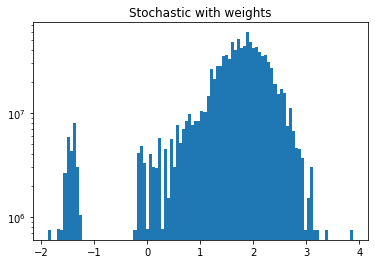

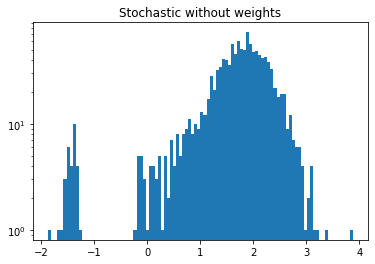

In [26]:
plt.hist(np.log10(new), bins=100,weights = weig)
#plt.xlim(0,60000)
plt.yscale('log')
plt.title('Stochastic with weights')

plt.show()


plt.hist(np.log10(new), bins=100)
plt.yscale('log')
plt.title('Stochastic without weights')

plt.show()

In [27]:
check = []
check1 = []
for i in range(len(losses)):
    if total_ar[i] == 0.0: check1.append(total_ar[i])
    if total_ar[i] == losses[i] == 0.0: check.append(losses[i])
    
print(len(check), len(check1)) #there are 155 zero elements of losses array and 105 zero elemnts in total_ar. 
#Only 50 elements are on the same possitions. Should I have weights for total_ar again. I think yes. 
#But how in this case have a histogram of total and stochastic with weights?

50 105


In [47]:
def func1(frame,frame_arr, counter_single,counter_multi_reject,  volume_radius, volume_top):
    pulses = frame['SRTInIcePulsesDOMeff'].apply(frame)
    one_dom = pulses.items()
  
            
    charge = []
    times = []
    min_time_ar = []
    for i in range(len(one_dom)):
        Omkey= one_dom[i][0]
        and_time = one_dom[i][1]
        #print(Omkey,and_time)

        value = []
        char = 0
        for pulse in one_dom[i][1]:
            time_pulse = 0
            time_pulse += pulse.time
            value.append(time_pulse)
            times.append(time_pulse)
        
            char += pulse.charge
            if char > 0 :
                charge.append(char)
    

    min_time_ar.append(min(value))

    #print(value)
    #print(min_time_ar)
    #print(times)
    #print(len(value))
    #print(len(times))
 
    
    for i in range(len(value)-1):
        #print(times[len(times) - i - 1])
        if times[len(times) - i - 1] != min_time_ar: del times[len(times) - i - 1]
    #print(times)

   
     
    
    gcd_file = '/cvmfs/icecube.opensciencegrid.org/data/GCD/GeoCalibDetectorStatus_IC86_Merged.i3.gz'
    gfile = dataio.I3File(gcd_file)
    gframe = gfile.pop_frame()
    geometry = gframe['I3Geometry']
    
    mydom = []
    for i in range(len(one_dom)):
        dom = geometry.omgeo[one_dom[i][0]]    
        mydom.append(dom) 
        
    mmctracks = frame['MMCTrackList']
    track = mmctracks[0].particle
    
    x_f = y_f = z_f = 0
    x_e = y_e = z_e = 0
    for i in range(len(mydom)):
        if times[i] == max(times):
            x_f = mydom[i].position.x
            y_f = mydom[i].position.y
            z_f = mydom[i].position.z
            
    for i in range(len(mydom)):
        if times[i] == min(times):
            x_e = mydom[i].position.x
            y_e = mydom[i].position.y
            z_e = mydom[i].position.z
   
    dis = np.sqrt((x_f - x_e)**2 + (y_f - y_e)**2 + (z_f - z_e)**2)
    
    distance = []
    for i in range(len(mydom)):
        d = phys_services.I3Calculator.cherenkov_distance(track, mydom[i].position)
        distance.append(d)
    #print(len(distance))
    #print(len(charge))
    
    corrected_charge = []
    for i in range(len(distance)):
        att_length = 50. 
        if distance[i] <= 200.0:
            corrected = charge[i]*distance[i]
            corrected_charge.append(corrected)
        
    
    return corrected_charge, dis, times, one_dom